# Kenyas Inflation Analysis( From: 1980 - 2024)
### Data Source: World Bank
[https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG?locations=KE]

In [19]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller # hypothesis testing
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import itertools
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from prophet import Prophet

import warnings

warnings.filterwarnings('ignore')

In [2]:
# Convert text to csv format
def convert_text_to_csv(input_file, output_csv):
    # read and process the file
    with open(input_file, 'r', encoding='utf-8') as f:
        lines = [line.strip().split('\t') for line in f.readlines()]

    # Extract Headers and data rows
    headers = []
    data_rows = []

    for parts in lines:
        cleaned = [part.strip() for part in parts if part.strip()]
        if not cleaned:
            continue
        if cleaned[0] == "Country Name":
            headers = cleaned
        elif cleaned[0] not in ["Data Source", "Last Updated Date"]:
            data_rows.append(cleaned)

    # Write to csv
    with open(output_csv, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(data_rows)

    return headers, data_rows


def extract_kenya_inflation(headers, data_rows):
    # Find Kenya data
    kenya_row = next((row for row in data_rows if row[0] == "Kenya"), None)
    if not kenya_row:
        return None

    # Creating Rate Pairs
    inflation_data = []
    for idx, header in enumerate(headers[4:], 4):  # skip first 4 metadata columns
        if header.isdigit() and 1980 <= int(header) <= 2024:
            try:
                value = kenya_row[idx] if kenya_row[idx] else "N/A"
                inflation_data.append({
                    "Year": header,
                    "Inflation Rate": value
                })
            except IndexError:
                inflation_data.append({
                    "Year": header,
                    "Inflation Rate": "N/A"
                })

    return inflation_data


# === Main logic ===
input_file = "./data/time_series_data.txt"
output_csv = "./data/economic_data.csv"

# Convert text file to CSV
headers, data_rows = convert_text_to_csv(input_file, output_csv)

# Extract Kenya's Data for 1980 - 2023
kenya_values = extract_kenya_inflation(headers, data_rows)

# Save to new CSV
if kenya_values:
    inflation_df = pd.DataFrame(kenya_values)
    inflation_df.to_csv("./data/kenya_inflation_data.csv", index=False)
    print("✅ Kenya inflation data saved to kenya_inflation_data.csv")
else:
    print("❌ Kenya data not found.")


✅ Kenya inflation data saved to kenya_inflation_data.csv


In [3]:
inflation_df['Year'] = pd.to_datetime(inflation_df['Year'], format='%Y')
inflation_df.head()

,Year,Inflation Rate
0,1980-01-01,13.8581814562484
1,1981-01-01,11.6030534351142
2,1982-01-01,20.6667146662827
3,1983-01-01,11.3977827368523
4,1984-01-01,10.284098213138


# Data Visualization

### Annotated Line Chart with Event Markers

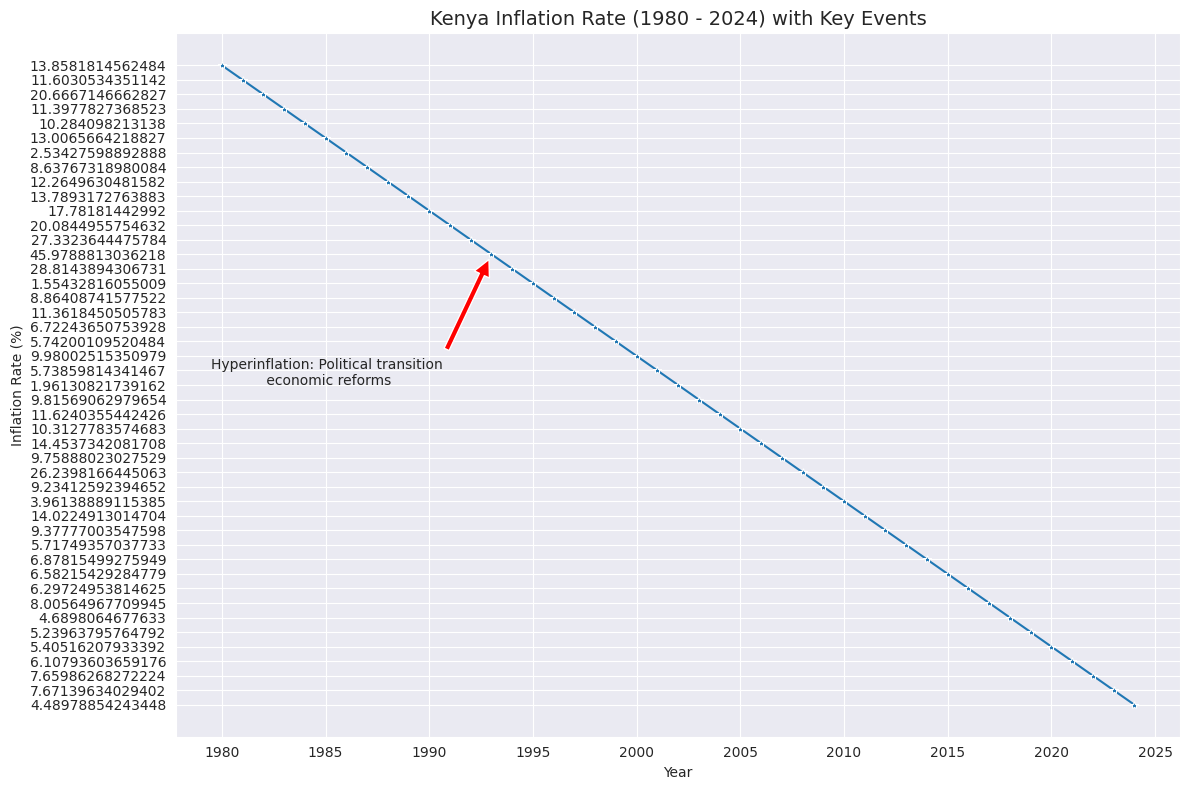

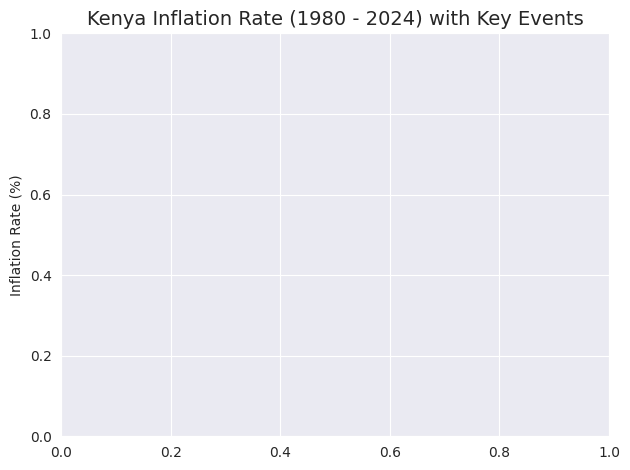

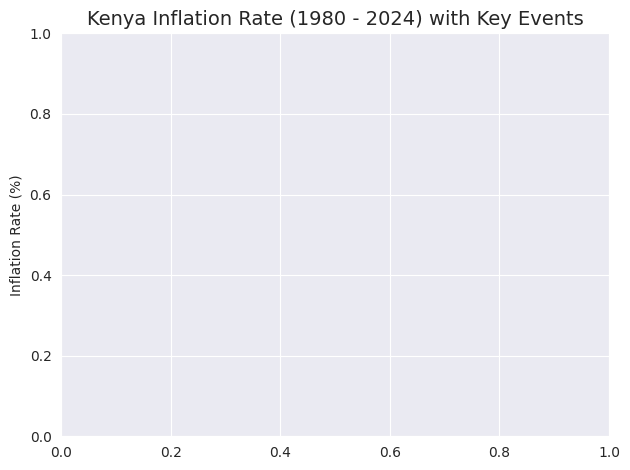

In [4]:
plt.figure(figsize=(12,8))
sns.set_style("darkgrid")
ax = sns.lineplot(x='Year', y='Inflation Rate', data=inflation_df, marker='*', color='#1f77b4')

#Annotate Key Events

events = {
    '1993' : ('Hyperinflation: Political transition\n economic reforms', (0.15, 0.5)),
    '2008' : ('Global financial crisis\n \& post-election violence', (0.7,0.8)),
    '2003' : ('Currency depreciation\n(20% vs USD)', (0.85, 0.25))

        }

for year, (text, xy) in events.items():
    y_value = inflation_df[inflation_df['Year'].dt.year ==int(year)]['Inflation Rate'].values[0]
    ax.annotate(text,
                xy=(pd.to_datetime(year),y_value),
                xytext=xy,
                textcoords='axes fraction',
                arrowprops = dict(facecolor='red', shrink=0.05),
                ha='center')
    plt.title('Kenya Inflation Rate (1980 - 2024) with Key Events', size=14)
    plt.ylabel('Inflation Rate (%)')
    plt.tight_layout()
    plt.show()
                    

### Rolling Average vs Annual Rates


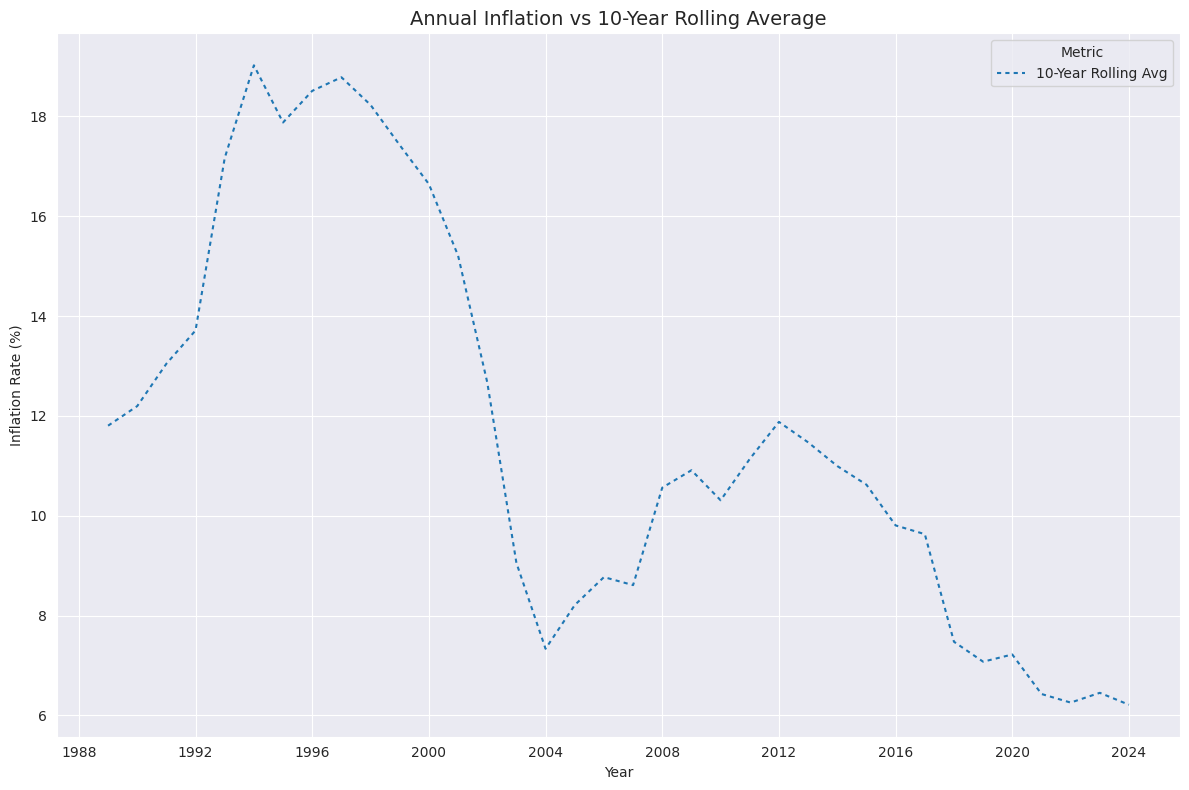

In [5]:
plt.figure(figsize=(12, 8))
inflation_df.set_index('Year', inplace=True)
inflation_df['10-Year Rolling Avg'] = inflation_df['Inflation Rate'].rolling(window=10).mean()

sns.lineplot(
    data=inflation_df[['Inflation Rate', '10-Year Rolling Avg']],
    dashes={'Inflation Rate': '', '10-Year Rolling Avg': (2, 2)},
    palette=['#1f77b4', '#ff7f0e']
)
plt.title('Annual Inflation vs 10-Year Rolling Average', size=14)
plt.ylabel('Inflation Rate (%)')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

# Stationarity of the original Series

In [6]:
# Test stationakrity of the original series
result = adfuller(inflation_df['Inflation Rate'])
print(f'ADF Statistics (d=1): { result[0]} p-value: {result[1]}')

ADF Statistics (d=1): -3.557479820582091 p-value: 0.006627930057036718


In [7]:
# Convert to column to numeric

inflation_df['Inflation Rate'] = pd.to_numeric(inflation_df['Inflation Rate'], errors ='coerce')

# Drop rows with NaN (if needed)
inflation_df =  inflation_df.dropna(subset=['Inflation Rate'])

# Check Stationarity

diff = inflation_df['Inflation Rate'].diff().dropna()

result_diff = adfuller(diff)

print(f'ADF Statistics (d-1): {result_diff[0] }, p-value: {result_diff[1]}')



ADF Statistics (d-1): -7.266771712333724, p-value: 1.6272856800472265e-10


### Plot  ACF and PACF for differenced series

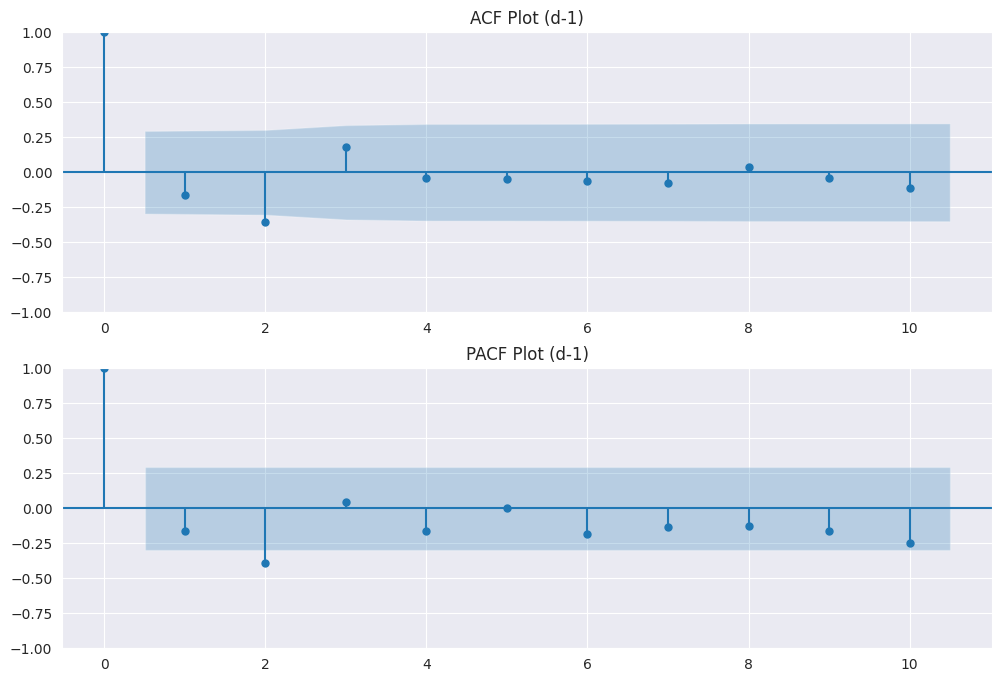

In [8]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(diff, lags=10, ax=ax1, title='ACF Plot (d-1)')
plot_pacf(diff, lags=10, ax=ax2, method='ywm', title='PACF Plot (d-1)')
plt.show()

### Test wider ranges for p and q

In [9]:

p = range(0, 4)  # AR terms: 0-3
q = range(0, 4)  # MA terms: 0-3
d = 1            # Differencing order

best_aic = float('inf')
best_order = None

for order in itertools.product(p, [d], q):
    try:
        model = ARIMA(inflation_df['Inflation Rate'], order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

print(f'Optimal Order: {best_order} (AIC: {best_aic})')


Optimal Order: (0, 1, 2) (AIC: 301.49547506707324)


## Modeling : ARIMA (0, 1, 2) & (2,1,1)

In [10]:
# Model 1: (0, 1, 2)
model_012 = ARIMA(inflation_df['Inflation Rate'], order=(0,1,2))
results_012 = model_012.fit()

# Model:2 (2, 1, 1)

model_211 = ARIMA(inflation_df['Inflation Rate'], order=(2,1,1))
results_211 = model_211.fit()

print(f'ARIMA(0,1,2) AIC: {results_012.aic}')
print(f'ARIMA(2,1,1) AIC: {results_211.aic}')

ARIMA(0,1,2) AIC: 301.49547506707324
ARIMA(2,1,1) AIC: 306.6333971961138


## Ljung-Box Test for Residual Autocorrelation

In [11]:
residuals_012 = results_012.resid
lb_test_012 = acorr_ljungbox(residuals_012, lags=10)

residuals_211 = results_211.resid
lb_test_211 = acorr_ljungbox(residuals_211, lags=10)

print("ARIMA(0,1,2) Residual p-values:\n", lb_test_012.lb_pvalue)
print("ARIMA(2,1,1) Residual p-values:\n", lb_test_211.lb_pvalue)

ARIMA(0,1,2) Residual p-values:
 1     0.668646
2     0.689315
3     0.826039
4     0.897699
5     0.927625
6     0.771136
7     0.768494
8     0.801053
9     0.854255
10    0.875998
Name: lb_pvalue, dtype: float64
ARIMA(2,1,1) Residual p-values:
 1     0.741622
2     0.939743
3     0.795997
4     0.871247
5     0.933528
6     0.778497
7     0.847067
8     0.894991
9     0.937968
10    0.965046
Name: lb_pvalue, dtype: float64


## Fit ARIMA (0,1,2)

In [12]:
model_arima = ARIMA(inflation_df['Inflation Rate'], order=(0,1,2))
results_arima = model_arima.fit()


## Forecast  5 Years

In [13]:
forecast_arima = results_arima.get_forecast(steps=5)
forecast_index = pd.date_range(start='2024', periods=5, freq='YS')

arima_forecast_df = pd.DataFrame({
    'Year': forecast_index.year,
    'Inflation Rate (ARIMA)': forecast_arima.predicted_mean,
    'Lower CI (ARIMA)': forecast_arima.conf_int().iloc[:,0],
    'Upper CI (ARIMA)': forecast_arima.conf_int().iloc[:,1]

})


## Prapare Prophet data for Forecasting

In [14]:
prophet_df = inflation_df.reset_index()[['Year', 'Inflation Rate']]
prophet_df.columns = ['ds', 'y'] # Rename to 'ds'(datetime) and 'y' (value)

# Convert 'ds' to datetime format(no need for .dt.to_timestampl_pr())
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])

# Fit prophet Model
model_prophet = Prophet(yearly_seasonality = False, changepoint_prior_scale=0.1)
model_prophet.fit(prophet_df)

# Forecast 5 years
future = model_prophet.make_future_dataframe(periods=5, freq='Y')
forecast_prophet = model_prophet.predict(future)

#Extract forecast results

prophet_forecast_df = forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)
prophet_forecast_df['Year'] = prophet_forecast_df['ds'].dt.year


17:02:27 - cmdstanpy - INFO - Chain [1] start processing
17:02:28 - cmdstanpy - INFO - Chain [1] done processing


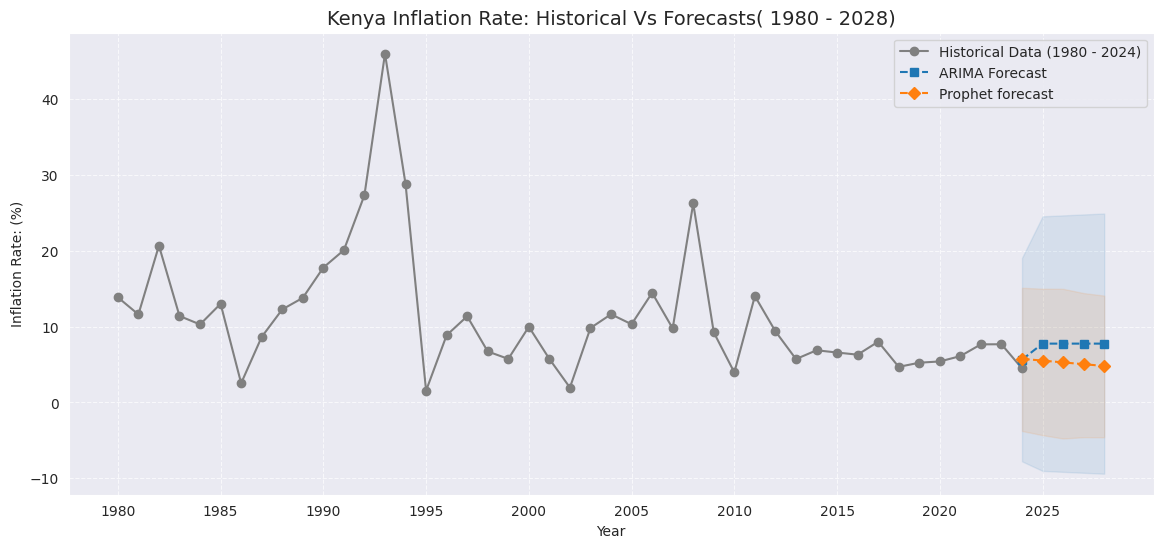

In [15]:
plt.figure(figsize=(14, 6))

# Historical data

plt.plot(inflation_df.index.year, inflation_df['Inflation Rate'],
         label = 'Historical Data (1980 - 2024)', color='grey', marker='o')


#ARIMA forecast(2024 - 2028)
plt.plot(arima_forecast_df['Year'], arima_forecast_df['Inflation Rate (ARIMA)'],
         label='ARIMA Forecast', color= '#1f77b4', linestyle='--', marker='s')
plt.fill_between(arima_forecast_df['Year'],
                 arima_forecast_df['Lower CI (ARIMA)'],
                 arima_forecast_df['Upper CI (ARIMA)'],
                 color='#1f77b4', alpha=0.1)

#Prophet forecast (2024 - 2028)
plt.plot(prophet_forecast_df['Year'], prophet_forecast_df['yhat'],
         label='Prophet forecast', color='#ff7f0e', linestyle='--', marker='D')

plt.fill_between(prophet_forecast_df['Year'],
                 prophet_forecast_df['yhat_lower'],
                 prophet_forecast_df['yhat_upper'],
                 color='#ff7f0e', alpha=0.1)


# Formatting

plt.title('Kenya Inflation Rate: Historical Vs Forecasts( 1980 - 2028)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Inflation Rate: (%)')
plt.xticks(range(1980, 2029, 5)) # 5 year interval
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [20]:
arima_forecast_df.to_csv(r"./results/arima_forecast.csv", index=False)
prophet_forecast_df.to_csv(r"./results/prophet_forecast.csv", index=False)